<a href="https://colab.research.google.com/github/NehaPunetha/Negation-handling-Analysis-DS-Theory/blob/main/Negation_hybride%2BDS_Theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

True_Label
Neutral     237
Positive    132
Negative    131
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



=== SieBERT + DS Fusion (Negation-Aware) ===
Accuracy: 0.434
              precision    recall  f1-score   support

    Negative       0.46      0.85      0.60       131
     Neutral       0.41      0.44      0.43       237
    Positive       0.00      0.00      0.00       132

    accuracy                           0.43       500
   macro avg       0.29      0.43      0.34       500
weighted avg       0.31      0.43      0.36       500



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


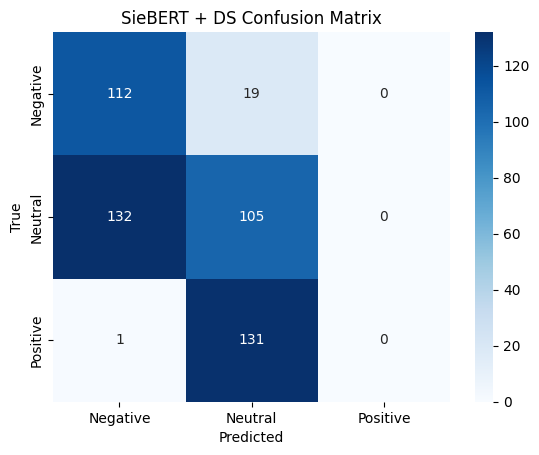

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("/content/Amazon_Negation_Reviews_Dataset_500.csv")
print(df['True_Label'].value_counts())

label2id = {"Negative":0, "Neutral":1, "Positive":2}
id2label = {v:k for k,v in label2id.items()}
labels = list(label2id.keys()) # Define the order of labels

# -----------------------------
# 2. Load SieBERT sentiment model
# -----------------------------
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# -----------------------------
# 3. DS Evidence Functions
# -----------------------------
def normalized_entropy(probs):
    H = -np.sum([p * math.log(p+1e-12) for p in probs])
    return H / math.log(len(probs))

def baseline_mass(probs):
    alpha = normalized_entropy(probs)
    return {c:(1-alpha)*p for c,p in zip(label2id.keys(), probs)} | {"Theta":alpha}

def negation_mass(rho=0.6):
    return {("Neutral","Positive"):rho, "Theta":1-rho}

def tone_mass(gamma=0.5):
    return {("Positive",):gamma, "Theta":1-gamma}

def combine(m1,m2):
    combined,conflict={},0
    for A,v1 in m1.items():
        for B,v2 in m2.items():
            setA = set(A) if isinstance(A,tuple) else set([A]) if A in label2id else set(label2id.keys())
            setB = set(B) if isinstance(B,tuple) else set([B]) if B in label2id else set(label2id.keys())
            inter = setA & setB
            if not inter: conflict+=v1*v2
            else:
                key=tuple(sorted(inter)) if len(inter)<3 else "Theta"
                combined[key]=combined.get(key,0)+v1*v2
    for k in combined: combined[k]/=(1-conflict+1e-12)
    return combined

def pignistic(m):
    BetP={c:0 for c in label2id}
    for A,mass in m.items():
        if A=="Theta": Aset=label2id.keys()
        elif isinstance(A,tuple): Aset=A
        elif A in label2id: Aset=[A]
        else: continue
        for c in Aset: BetP[c]+=mass/len(Aset)
    return BetP

# -----------------------------
# 4. DS Fusion Prediction
# -----------------------------
def ds_predict(text, has_neg=False):
    scores = classifier(text)[0]
    logits = np.array([s["score"] for s in scores])  # [Neg, Neu, Pos]

    m_base = baseline_mass(logits)
    m_neg = negation_mass() if has_neg else {"Theta":1.0}
    m_tone = tone_mass() if "at all" in text.lower() else {"Theta":1.0}

    m_fused = combine(m_base,m_neg)
    m_fused = combine(m_fused,m_tone)

    BetP = pignistic(m_fused)
    return max(BetP, key=BetP.get)

# -----------------------------
# 5. Evaluation
# -----------------------------
y_true, y_pred = [], []
for _, row in df.iterrows():
    y_true.append(row["True_Label"])
    y_pred.append(ds_predict(row["Review"], bool(row["Has_Negation"])))

print("\n=== SieBERT + DS Fusion (Negation-Aware) ===")
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=labels)) # Use the defined labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels) # Use the defined labels
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SieBERT + DS Confusion Matrix")
plt.show()

**With Binary Class classification**

Dataset size: 500
True_Label
Neutral     237
Positive    132
Negative    131
Name: count, dtype: int64

=== Baseline SieBERT ===
Accuracy: 0.9201520912547528
              precision    recall  f1-score   support

    Negative       0.98      0.85      0.91       131
    Positive       0.87      0.98      0.93       132

    accuracy                           0.92       263
   macro avg       0.93      0.92      0.92       263
weighted avg       0.93      0.92      0.92       263



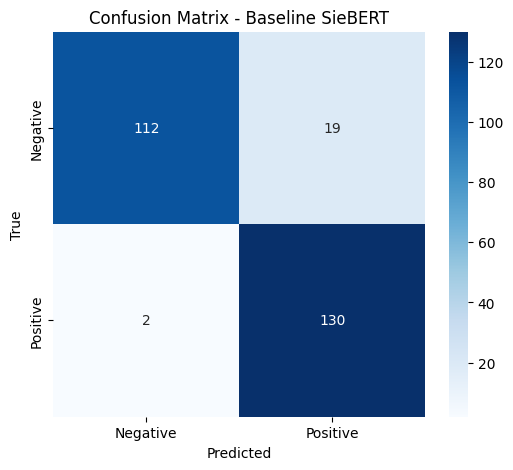


=== DS Fusion (SieBERT + Negation) ===
Accuracy: 0.9239543726235742
              precision    recall  f1-score   support

    Negative       0.99      0.85      0.92       131
    Positive       0.87      0.99      0.93       132

    accuracy                           0.92       263
   macro avg       0.93      0.92      0.92       263
weighted avg       0.93      0.92      0.92       263



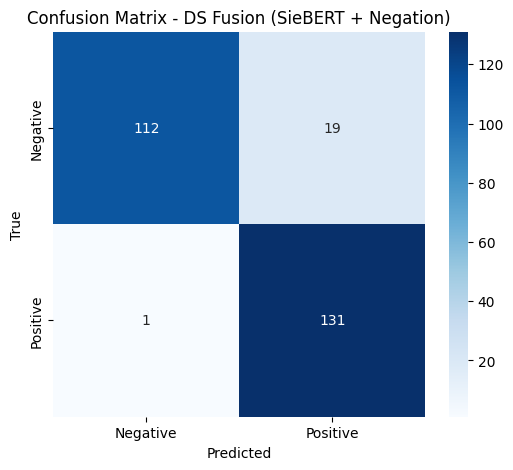


=== Hybrid SieBERT + DS (confidence-aware) ===
Accuracy: 0.9239543726235742
              precision    recall  f1-score   support

    Negative       0.99      0.85      0.92       131
    Positive       0.87      0.99      0.93       132

    accuracy                           0.92       263
   macro avg       0.93      0.92      0.92       263
weighted avg       0.93      0.92      0.92       263



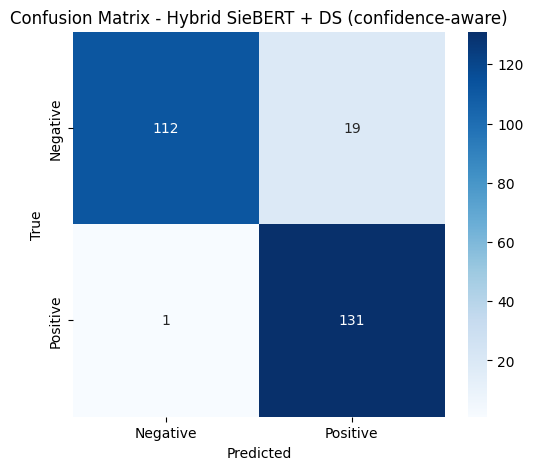

In [ ]:
import numpy as np
import torch
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("/content/Binary_Negation_Reviews_Dataset_500.csv")
print("Dataset size:", len(df))
print(df['True_Label'].value_counts())

# Only keep Positive/Negative
df = df[df["True_Label"].isin(["Positive", "Negative"])].reset_index(drop=True)

# -----------------------------
# Load SieBERT model (binary Pos/Neg)
# -----------------------------
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

CLASSES = ["Negative", "Positive"]

# -----------------------------
# DS Theory helper functions
# -----------------------------
def normalized_entropy(probs):
    H = -np.sum([p * math.log(p + 1e-12) for p in probs])
    H_max = math.log(len(probs))
    return H / H_max if H_max > 0 else 0.0

def baseline_mass(probs):
    alpha = normalized_entropy(probs)
    return {
        "Negative": (1 - alpha) * probs[0],
        "Positive": (1 - alpha) * probs[1],
        "Theta": alpha
    }

def negation_mass(rho=0.4):
    return {("Positive",): rho, "Theta": 1 - rho}

def tone_mass(gamma=0.6):
    return {("Positive",): gamma, "Theta": 1 - gamma}

def combine(m1, m2):
    combined, conflict = {}, 0.0
    for A, v1 in m1.items():
        for B, v2 in m2.items():
            setA = set(A) if isinstance(A, tuple) else {A} if A in CLASSES else set(CLASSES)
            setB = set(B) if isinstance(B, tuple) else {B} if B in CLASSES else set(CLASSES)
            inter = setA & setB
            if not inter:
                conflict += v1 * v2
            else:
                key = tuple(sorted(inter)) if len(inter) == 1 else "Theta"
                combined[key] = combined.get(key, 0) + v1 * v2
    for k in combined:
        combined[k] /= (1 - conflict + 1e-12)
    return combined

def pignistic(m):
    BetP = {c: 0.0 for c in CLASSES}
    for A, mass in m.items():
        if A == "Theta":
            Aset = CLASSES
        elif isinstance(A, tuple):
            Aset = list(A)
        elif A in CLASSES:
            Aset = [A]
        else:
            continue
        for c in Aset:
            BetP[c] += mass / len(Aset)
    return BetP

# -----------------------------
# Prediction pipelines
# -----------------------------
def baseline_predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]  # [Neg, Pos]
    pred = CLASSES[np.argmax(probs)]
    conf = np.max(probs)
    return pred, probs, conf

def ds_predict(text, has_negation=False):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]

    m_base = baseline_mass(probs)
    m_neg = negation_mass(rho=0.4) if has_negation else {"Theta": 1.0}
    m_tone = tone_mass(gamma=0.6) if "at all" in text.lower() else {"Theta": 1.0}

    m_fused = combine(m_base, m_neg)
    m_fused = combine(m_fused, m_tone)

    BetP = pignistic(m_fused)
    y_pred = max(BetP, key=BetP.get)
    return y_pred, BetP

def hybrid_predict(text, has_negation=False, threshold=0.65):
    base_pred, probs, conf = baseline_predict(text)
    if conf >= threshold:
        return base_pred
    elif has_negation:
        ds_pred, _ = ds_predict(text, has_negation)
        return ds_pred
    return base_pred

# -----------------------------
# Evaluation
# -----------------------------
def evaluate(predict_func, name):
    y_true, y_pred = [], []
    for _, row in df.iterrows():
        text = row["Review"]
        has_neg = bool(row["Has_Negation"])
        true_label = row["True_Label"]
        pred = predict_func(text, has_neg)
        y_true.append(true_label)
        y_pred.append(pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    cm = confusion_matrix(y_true, y_pred, labels=CLASSES)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    return acc

# -----------------------------
# Run evaluations
# -----------------------------
acc_base = evaluate(lambda t,h: baseline_predict(t)[0], "Baseline SieBERT")
acc_ds = evaluate(lambda t,h: ds_predict(t, h)[0], "DS Fusion (SieBERT + Negation)")
acc_hybrid = evaluate(hybrid_predict, "Hybrid SieBERT + DS (confidence-aware)")


**with -dataset-with-binary-dataset-only**

Dataset size: 500
True_Label
1    250
0    250
Name: count, dtype: int64

=== Baseline SieBERT ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       250
           1       1.00      0.89      0.94       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



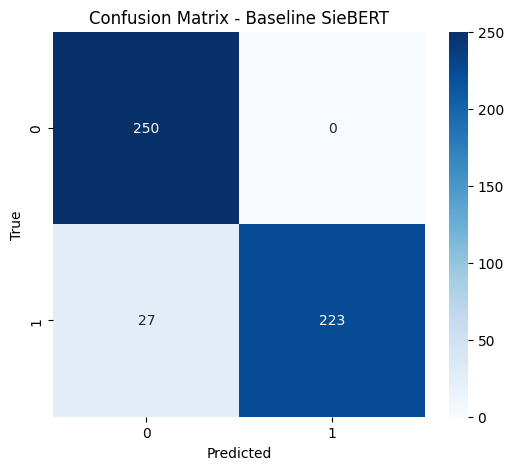


=== DS Fusion (SieBERT + Negation) ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       250
           1       1.00      0.89      0.94       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



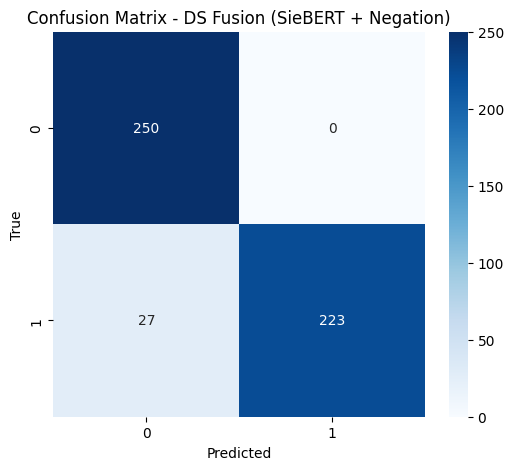


=== Hybrid SieBERT + DS (confidence-aware) ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       250
           1       1.00      0.89      0.94       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



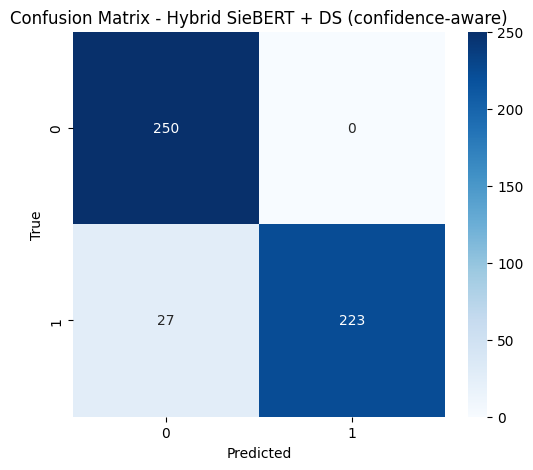

In [ ]:
import numpy as np
import torch
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("/content/Binary_Negation_Reviews_Dataset_500.csv")
print("Dataset size:", len(df))
print(df['True_Label'].value_counts())

# -----------------------------
# Load SieBERT model (binary Pos/Neg)
# -----------------------------
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

CLASSES = [0, 1] # Update classes to match the dataset labels

# -----------------------------
# DS Theory helper functions
# -----------------------------
def normalized_entropy(probs):
    H = -np.sum([p * math.log(p + 1e-12) for p in probs])
    H_max = math.log(len(probs))
    return H / H_max if H_max > 0 else 0.0

def baseline_mass(probs):
    alpha = normalized_entropy(probs)
    # Update to use numerical labels
    return {
        0: (1 - alpha) * probs[0],
        1: (1 - alpha) * probs[1],
        "Theta": alpha
    }

def negation_mass(rho=0.4):
    # Update to use numerical labels
    return {(1,): rho, "Theta": 1 - rho}

def tone_mass(gamma=0.6):
    # Update to use numerical labels
    return {(1,): gamma, "Theta": 1 - gamma}


def combine(m1, m2):
    combined, conflict = {}, 0.0
    for A, v1 in m1.items():
        for B, v2 in m2.items():
            # Update to handle numerical labels and "Theta"
            setA = set(A) if isinstance(A, tuple) else {A} if A in CLASSES else set(CLASSES)
            setB = set(B) if isinstance(B, tuple) else {B} if B in CLASSES else set(CLASSES)
            inter = setA & setB
            if not inter:
                conflict += v1 * v2
            else:
                key = tuple(sorted(inter)) if len(inter) == 1 and isinstance(list(inter)[0], int) else "Theta" # Handle single numerical label
                combined[key] = combined.get(key, 0) + v1 * v2
    for k in combined:
        combined[k] /= (1 - conflict + 1e-12)
    return combined

def pignistic(m):
    BetP = {c: 0.0 for c in CLASSES}
    for A, mass in m.items():
        if A == "Theta":
            Aset = CLASSES
        elif isinstance(A, tuple):
            Aset = list(A)
        elif A in CLASSES:
            Aset = [A]
        else:
            continue
        for c in Aset:
            BetP[c] += mass / len(Aset)
    return BetP

# -----------------------------
# Prediction pipelines
# -----------------------------
def baseline_predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]  # [Neg, Pos]
    pred = CLASSES[np.argmax(probs)]
    conf = np.max(probs)
    return pred, probs, conf

def ds_predict(text, has_negation=False):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]

    m_base = baseline_mass(probs)
    m_neg = negation_mass(rho=0.4) if has_negation else {"Theta": 1.0}
    m_tone = tone_mass(gamma=0.6) if "at all" in text.lower() else {"Theta": 1.0}

    m_fused = combine(m_base, m_neg)
    m_fused = combine(m_fused, m_tone)

    BetP = pignistic(m_fused)
    y_pred = max(BetP, key=BetP.get)
    return y_pred, BetP

def hybrid_predict(text, has_negation=False, threshold=0.65):
    base_pred, probs, conf = baseline_predict(text)
    if conf >= threshold:
        return base_pred
    elif has_negation:
        ds_pred, _ = ds_predict(text, has_negation)
        return ds_pred
    return base_pred


# -----------------------------
# Evaluation
# -----------------------------
def evaluate(predict_func, name):
    y_true, y_pred = [], []
    for _, row in df.iterrows():
        text = row["Review"]
        has_neg = bool(row["Has_Negation"])
        true_label = row["True_Label"]
        pred = predict_func(text, has_neg)
        y_true.append(true_label)
        y_pred.append(pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    # Update target_names to match the numerical labels
    print(classification_report(y_true, y_pred, target_names=[str(c) for c in CLASSES]))
    cm = confusion_matrix(y_true, y_pred, labels=CLASSES)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=[str(c) for c in CLASSES], yticklabels=[str(c) for c in CLASSES], cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    return acc

# -----------------------------
# Run evaluations
# -----------------------------
acc_base = evaluate(lambda t,h: baseline_predict(t)[0], "Baseline SieBERT")
acc_ds = evaluate(lambda t,h: ds_predict(t, h)[0], "DS Fusion (SieBERT + Negation)")
acc_hybrid = evaluate(hybrid_predict, "Hybrid SieBERT + DS (confidence-aware)")

Latest-updated

Dataset size: 3000
true_label
Negative    1595
Positive    1405
Name: count, dtype: int64

=== Baseline SieBERT ===
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00      1595
    Positive       1.00      0.99      1.00      1405

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



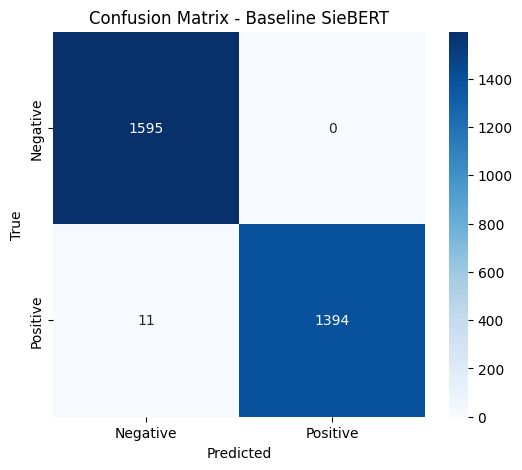


=== DS Fusion (SieBERT + Negation) ===
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00      1595
    Positive       1.00      0.99      1.00      1405

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



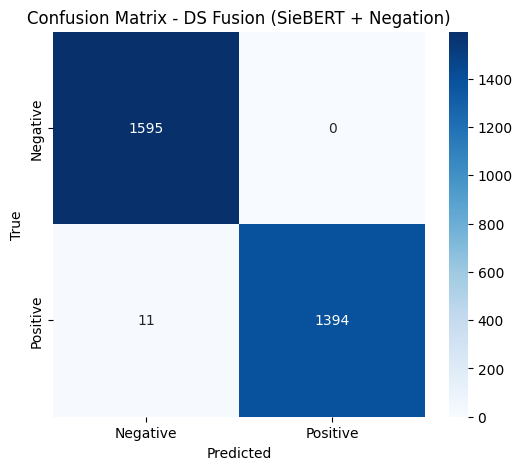


=== Hybrid SieBERT + DS (confidence-aware) ===
              precision    recall  f1-score   support

    Negative       0.99      1.00      1.00      1595
    Positive       1.00      0.99      1.00      1405

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



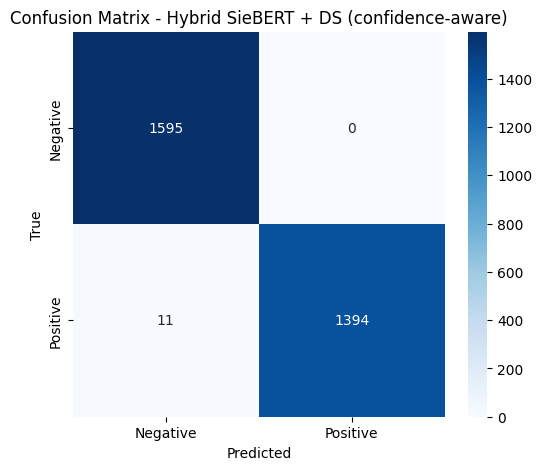

In [ ]:
import numpy as np
import torch
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_csv("/content/amazon_negation_3000.csv")
print("Dataset size:", len(df))
print(df['true_label'].value_counts()) # Corrected column name

# -----------------------------
# Load SieBERT model (binary Pos/Neg)
# -----------------------------
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

CLASSES = ["Negative", "Positive"] # Updated classes to match string labels

# -----------------------------
# DS Theory helper functions
# -----------------------------
def normalized_entropy(probs):
    H = -np.sum([p * math.log(p + 1e-12) for p in probs])
    H_max = math.log(len(probs))
    return H / H_max if H_max > 0 else 0.0

def baseline_mass(probs):
    alpha = normalized_entropy(probs)
    # Update to use string labels
    return {
        "Negative": (1 - alpha) * probs[0],
        "Positive": (1 - alpha) * probs[1],
        "Theta": alpha
    }

def negation_mass(rho=0.4):
    # Update to use string labels
    return {("Positive",): rho, "Theta": 1 - rho}

def tone_mass(gamma=0.6):
    # Update to use string labels
    return {("Positive",): gamma, "Theta": 1 - gamma}


def combine(m1, m2):
    combined, conflict = {}, 0.0
    for A, v1 in m1.items():
        for B, v2 in m2.items():
            # Update to handle string labels and "Theta"
            setA = set(A) if isinstance(A, tuple) else {A} if A in CLASSES else set(CLASSES)
            setB = set(B) if isinstance(B, tuple) else {B} if B in CLASSES else set(CLASSES)
            inter = setA & setB
            if not inter:
                conflict += v1 * v2
            else:
                key = tuple(sorted(inter)) if len(inter) == 1 and list(inter)[0] in CLASSES else "Theta" # Handle single string label
                combined[key] = combined.get(key, 0) + v1 * v2
    for k in combined:
        combined[k] /= (1 - conflict + 1e-12)
    return combined


def pignistic(m):
    BetP = {c: 0.0 for c in CLASSES}
    for A, mass in m.items():
        if A == "Theta":
            Aset = CLASSES
        elif isinstance(A, tuple):
            Aset = list(A)
        elif A in CLASSES:
            Aset = [A]
        else:
            continue
        for c in Aset:
            BetP[c] += mass / len(Aset)
    return BetP

# -----------------------------
# Prediction pipelines
# -----------------------------
def baseline_predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]  # [Neg, Pos]
    pred = CLASSES[np.argmax(probs)]
    conf = np.max(probs)
    return pred, probs, conf

def ds_predict(text, has_negation=False):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]

    m_base = baseline_mass(probs)
    m_neg = negation_mass(rho=0.4) if has_negation else {"Theta": 1.0}
    m_tone = tone_mass(gamma=0.6) if "at all" in text.lower() else {"Theta": 1.0}

    m_fused = combine(m_base, m_neg)
    m_fused = combine(m_fused, m_tone)

    BetP = pignistic(m_fused)
    y_pred = max(BetP, key=BetP.get)
    return y_pred, BetP

def hybrid_predict(text, has_negation=False, threshold=0.65):
    base_pred, probs, conf = baseline_predict(text)
    if conf >= threshold:
        return base_pred
    elif has_negation:
        ds_pred, _ = ds_predict(text, has_negation)
        return ds_pred
    return base_pred


# -----------------------------
# Evaluation
# -----------------------------
def evaluate(predict_func, name):
    y_true, y_pred = [], []
    for _, row in df.iterrows():
        text = row["review_text"] # Corrected column name
        has_neg = bool(row["has_negation"]) # Corrected column name
        true_label = row["true_label"] # Corrected column name
        pred = predict_func(text, has_neg)
        y_true.append(true_label)
        y_pred.append(pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    # Update target_names to match the string labels
    print(classification_report(y_true, y_pred, target_names=CLASSES))
    cm = confusion_matrix(y_true, y_pred, labels=CLASSES)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=CLASSES, yticklabels=CLASSES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    return acc

# -----------------------------
# Run evaluations
# -----------------------------
acc_base = evaluate(lambda t,h: baseline_predict(t)[0], "Baseline SieBERT")
acc_ds = evaluate(lambda t,h: ds_predict(t, h)[0], "DS Fusion (SieBERT + Negation)")
acc_hybrid = evaluate(hybrid_predict, "Hybrid SieBERT + DS (confidence-aware)")